# Downloading Libraries

In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece
#!pip install transformers
!pip install transformers~=2.11.0
!pip install -q tf-models-official

# Import the necessary packages

In [ ]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

# Common Functions

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

  # function to get unique values 
def unique(list1):
    
    global unique_list
          
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    #for x in unique_list: 
        #print(x)
        
def plot_history(history):
#dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])        
#dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(18, 10))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training Accuracy')
    plt.plot(x, val_acc, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Model Loss')
    plt.legend()



print(__doc__)
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return '{p:.2f}%  ({v:d})'.format(p=pct, v=val)
        return my_autopct

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct=make_autopct(sizes))
    ax.axis('equal')


import re
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

Automatically created module for IPython interactive environment


# Data Exploration

In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from collections import Counter
from transformers import BertForSequenceClassification
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/all_tickets_processed_3topics.csv")

df.isnull().values.any()
df= df.drop('title', axis=1)
df.shape
df.head()
print(df['Target'].value_counts())

labels = df['Target']
samples = df['body']


2    23526
0    17734
1     7289
Name: Target, dtype: int64


# Training and Test DataSets

In [ ]:
from sklearn.model_selection import train_test_split

reviews = []
sentences = list(samples)
for sen in sentences:
    reviews.append(preprocess_text(sen))

possible_labels = df.Target.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

df['label'] = df.Target.replace(label_dict)

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)


df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby([ 'label', 'data_type']).count()


body  Target
label data_type               
0     train       6195    6195
      val         1094    1094
1     train      19997   19997
      val         3529    3529
2     train      15074   15074
      val         2660    2660

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


DataSet before imbalanced fix...........


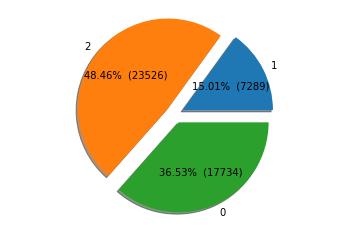

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy1 = 'not majority'
print("DataSet before imbalanced fix...........")
plot_pie(labels)


DataSet after imbalanced fix...........


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


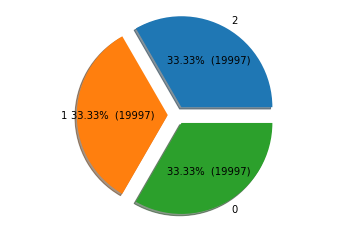

In [ ]:
rus1 = RandomOverSampler(sampling_strategy=sampling_strategy1)
x_train_im, y_train_im = rus1.fit_resample(X_train.reshape(-1,1), y_train)
print("DataSet after imbalanced fix...........")

plot_pie(y_train_im)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].body.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].body.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)


# Model Build

In [ ]:
from official.nlp import optimization  # to create AdamW optmizer

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)


from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)



from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)



In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Training Model

In [ ]:
import time
import datetime

# Specify loss function
loss_fn = nn.CrossEntropyLoss()
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

for epoch in tqdm(range(1, epochs+1)):
    
    # Measure how long the training epoch takes.
    t0 = time.time()
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        import torch
        
        device = torch.device("cuda")    
        torch.cuda.empty_cache()
        if(torch.cuda.is_available()):
          model.cuda()# rnn is your model 
        
        outputs = model(**inputs)

## Specify loss function

        loss = outputs[0]
        #loss = loss_fn(outputs, batch[2])

        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
        
    # Measure how long this epoch took.
    training_time = time.time() - t0

    t0 = time.time()

    val_loss, predictions, true_vals = evaluate(dataloader_validation)

    # Measure how long the validation run took.
    validation_time = time.time() - t0
        
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

    val_acc= accuracy(predictions, true_vals)
    tqdm.write(f'val_accuracy: {val_acc}') 
    
     # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch ,
            'Training Loss': loss_train_avg,
            'Valid. Loss': val_loss,
            'Valid. Accur': val_acc,
            'F1 Score (Weighted).': val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )


Epoch 1
Training loss: 0.45145408559677214
Validation loss: 0.28499811188432206
F1 Score (Weighted): 0.8883960730963238
val_accuracy: 0.8887820952904023



Epoch 2
Training loss: 0.25806957320129686
Validation loss: 0.2458743533577051
F1 Score (Weighted): 0.9034712671204836
val_accuracy: 0.903611149251682



Epoch 3
Training loss: 0.18607097336545933
Validation loss: 0.24249194009360253
F1 Score (Weighted): 0.9105692011958234
val_accuracy: 0.9106137580667307



Epoch 4
Training loss: 0.14156589765181085
Validation loss: 0.24270095550373458
F1 Score (Weighted): 0.9133437129415055
val_accuracy: 0.9136344912810654



Epoch 5
Training loss: 0.10766976754534845
Validation loss: 0.2727268472509949
F1 Score (Weighted): 0.9195990932250215
val_accuracy: 0.919538651654538



In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur,F1 Score (Weighted).,Training Time,Validation Time
epoch,,,,,,
1,0.45,0.28,0.89,0.89,2006.46,114.63
2,0.26,0.25,0.90,0.90,2001.61,115.08
3,0.19,0.24,0.91,0.91,1999.18,115.10
4,0.14,0.24,0.91,0.91,2000.88,115.04
5,0.11,0.27,0.92,0.92,1999.49,114.90


# Evaluate Model Performance and Prediction

In [21]:

#len(label_dict)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

import torch
device = torch.device("cuda") 
model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/finetuned_BERT_epoch_5.model', map_location=torch.device('cpu')))
_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)
accuracy(predictions, true_vals)


Class: 1
Accuracy: 965/1094

Class: 2
Accuracy: 3264/3529

Class: 0
Accuracy: 2468/2660



0.919538651654538